# Тестирование двойственного алгоритма решения задачи минимизации максимального запаздывания

### Импорты

In [1]:
import time
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

### Парсинг примеров

In [2]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=int)
    s = s.reshape((len(s)//3, 3))
    return s

### Класс "Расписание"

In [3]:
class Schedule:
    """
    A wrap around arrays of shape (n, 3), 
    where n is the number of jobs in the schedule
    and each job parameters are ordered as follows:
    r | p | d
    """
    array = None
    
    def enum(self):
        if len(self.array) > 0:
            a = np.append(self.array, np.ones((len(self.array), 1)), axis=1)
            for i, _ in enumerate(a):
                a[i, 3] += i
            self.array = a.astype(int)
    
    def __init__(self, array, Enumerate=False):
        """
        Arguments:
        - array: int or list/np.ndarray
        if int, the schedule is generated randomly and contains n elements
        if list/np.ndarray/etc., the array is directly transformed into schedule
        """
        if isinstance(array, int):
            self.array = np.random.randint(1, 1000, size=(array, 3))
            # for non-negative time slack
            self.array[:,2] = self.array[:,2] + self.array[:,1] + self.array[:,0]
        else: self.array = np.copy(array)
        if Enumerate: self.enum()
    
    def show(self):
        print(" r  |  p  |  d  | num ")
        print(self.array)
        
    def sort(self, item=0):
        self.array = self.array[self.array[:,item].argsort()]
        
    def remove(self, B):
        idx = []
        for i, e in enumerate(np.isin(self.array, B)):
            if e.all():
                idx.append(i)
        self.array = np.delete(self.array, idx, axis=0)
    
    def pop(self, index=-1):
        e = self.array[index]
        self.array = np.delete(self.array, index, axis=0)
        return e
    
    def copy(self):
        return Schedule(np.copy(self.array))
    
    def insert(self, index, elem):
        self.array = np.insert(self.array, index, elem, axis=0)
        
    def length(self):
        return self.array.shape[0]
    
    def C(self, j=None):
        t = 0
        for task in self.array[:j]:
            if t < task[0]:
                t = task[0]
            t += task[1]
        return t
    
    def timeshift(self, tau):
        for i in range(self.length()):
            self.array[i,0] -= tau
            
    def L_max(self, tau=0):
        if len(self.array) == 0:
            return float('inf')
        a = self.copy()
        a.timeshift(tau)
        return max([self.C(j+1) - a.array[j,2] for j in range(len(a.array))]) + tau


### Алгоритм решения двойственной задачи

In [43]:
def dual(N, tau, B):
    pi_r = N.copy()
    pi_r.remove(B)
    pi_r.timeshift(tau)
    if pi_r.length() > 0:
        pi_r.sort()
    else: return 0, 0
    bestC = pi_r.C()
    bestI = 0
    # todo: set the condition
    if True:
        for k, e in enumerate(pi_r.array):
            pi_k = pi_r.copy()
            i_k = pi_k.pop(k)
            if pi_k.length() > 0:
                i_l = pi_k.pop(np.argmin(pi_k.array, axis=0)[0])
                pi_k.insert(pi_k.length(), i_k)
                pi_k.insert(0, i_l)
                C_k = pi_k.C()
                if C_k < bestC:
                    print("CH!")
                    bestC = C_k
                    bestI = k
        return bestC + tau, bestI
        

### Класс "пример"
Содержит все параметры примера, указанные в статье: $N,\tau, \nu, \pi, B$, при чём $\nu$ автоматически вычисляется применением двойственного алгоритма к $N$

In [5]:
class Instance:
    
    def __init__(self, N, tau, pi=Schedule([]), B=[]):
        """
        Arguments:
        - N - Schedule object
        - tau - int or (possibly) float
        - pi - Schedule object
        - B - list
        """
        self.N = N.copy()
        self.tau = tau
        self.nu = dual(N, tau, B)[0]
        self.pi = pi.copy()
        self.B = B.copy()
        
    def best_job(self):
        N1 = self.N.copy()
        N1.remove(self.B)
        if len(N1.array) == 0:
            return
        a = N1.array[N1.array[:,0] <= self.tau]
        if len(a) == 0:
            self.tau = np.min(N1.array[:,0], axis=0)
            a = N1.array[N1.array[:,0] <= self.tau]
        f = min(a, key=lambda x: x[2])
        return f

### Алгоритм решения задачи $1|r_j|L_{max}$

In [49]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 1200

def main(N, tau=0):
    #tb = time.time() - !таймаут отключен!
    c = 0
    bestPi = Schedule([])    
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        #ti = time.time()
        #if ti - tb > timeout:
        #    return Schedule([]), -1
        index, instance = min(
            enumerate(instances),
            key=lambda x: max(x[1].nu, x[1].pi.L_max()) - x[1].pi.length()/N.length()/10
        )
        f = instance.best_job()
        instances.pop(index)
        if f is not None:
            
            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)
            
            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            c += 1
            #pi1.show()
            if pi1.length() == N.length():
                if max(pi1.L_max(tau), dual(pi1, tau, [])[0]) < max(bestPi.L_max(tau), dual(bestPi, tau, [])[0]):
                    bestPi = pi1.copy()
            instances = [i for i in instances
                         if max(dual(i.pi, tau, [])[0], i.pi.L_max(tau)) < max(bestPi.L_max(tau), dual(bestPi, tau, [])[0])]

    return bestPi, c

### Алгоритм перебора *всех* возможных вариантов

In [7]:
def bruteforce(S, tau=0):
    N = np.copy(S.array)
    best_L = Schedule(N).L_max(tau)
    best_S = N
    for p in permutations(N):
        L = Schedule(p).L_max(tau)
        if L < best_L:
            best_L = L
            best_S = p
    return Schedule(best_S)

# Тестирование

In [78]:
s = Schedule(5)
s.show()
r = main(s)
r[0].show()

 r  |  p  |  d  | num 
[[ 124  233  857]
 [ 376  249  991]
 [ 509  102  752]
 [ 268  490  849]
 [ 851  567 2339]]
 r  |  p  |  d  | num 
[[ 124  233  857]
 [ 268  490  849]
 [ 509  102  752]
 [ 376  249  991]
 [ 851  567 2339]]


In [11]:
b = bruteforce(s)

In [13]:
b.show()

 r  |  p  |  d  | num 
[[  82  687  892]
 [ 344  100 1191]
 [ 511  656 1656]
 [ 102  802 1706]
 [ 878  593 1749]]


In [15]:
b.L_max()

1171

In [70]:
r = main(s)

In [20]:
r[0].L_max()

1171

In [71]:
r[0].show()

 r  |  p  |  d  | num 
[[ 274  651 1565]
 [ 371  514  979]
 [ 865  240 1371]
 [ 626  156 1619]
 [ 574  836 1987]]


In [79]:
rL, bL = 0, 0
while rL == bL:
    s = Schedule(5)
    b = bruteforce(s)
    r = main(s)
    bL = b.L_max()
    rL = r[0].L_max()
    print("\r", bL, end='')

 4454

In [58]:
rL

373

In [62]:
b.show()

 r  |  p  |  d  | num 
[[  33  870  937]
 [  37  597 1058]
 [ 417   39 1155]
 [ 508  284 1464]
 [  24  613 1508]]


In [65]:
r[0].show()

 r  |  p  |  d  | num 
[[  24  613 1508]
 [  33  870  937]
 [  37  597 1058]
 [ 417   39 1155]
 [ 508  284 1464]]


### Оценка сложности алгоритма
Метрика - количество узлов ветвления

In [ ]:
results = dict()
for n in range(10, 101, 5):
    results[n] = []
    for i in range(1):
        print('\r', len(results[n]), end='')
        t = 0
        s = Schedule(n)
        timing = %timeit -q -o -r 5 main(s, t)
        results[n].append(np.mean(timing.timings))
    print(" --", n, "tasks")
    
    json.dump(results, open('results_timings.json', 'w'))

### Примеры малой размерности

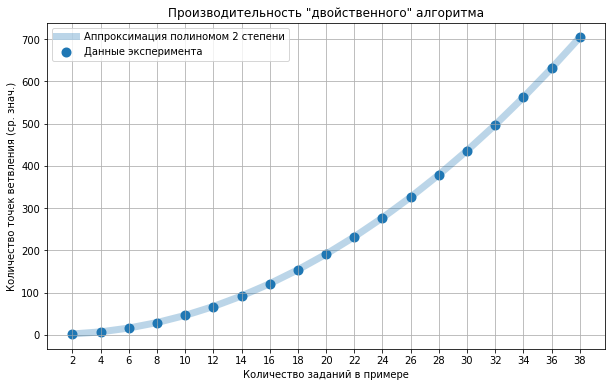

In [0]:
x = []
y = []
#yf = []
for k in results2.keys():
    y.append(np.median(results2[k]))
    x.append(k)
    #yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](list(map(int, x))),
        label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

### Примеры большой размерности

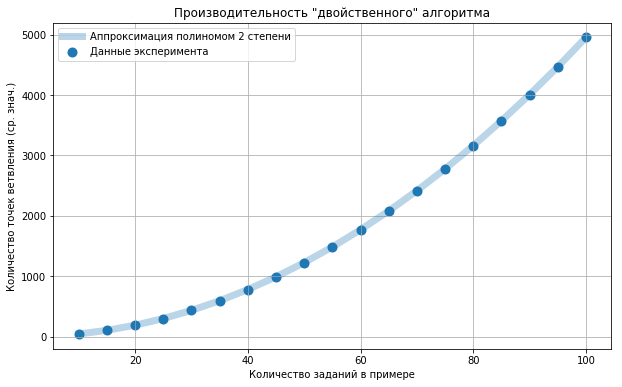

In [0]:
x = []
y = []
for k in results.keys():
    y.append(np.median(results[k]))
    x.append(k)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
i = 1
ax.plot(x, z[1](x), label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

## Проверка быстродействия
Метрика - время выполнения алгоритма

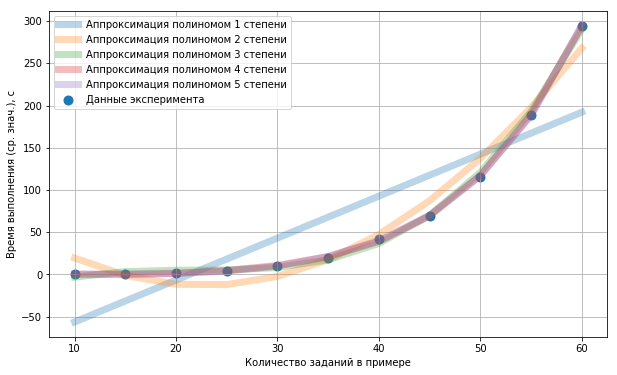

In [50]:
x = list(results.keys())[:-1]
y = list(map(lambda x: x[0], list(results.values())[:-1]))
z = [approx(x, y, i) for i in range(1, 6)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
for i in range(5):
    ax.plot(x, z[i](x), label='Аппроксимация полиномом %s степени' % (i+1),
        linewidth=7,
        alpha=0.3)
ax.legend()

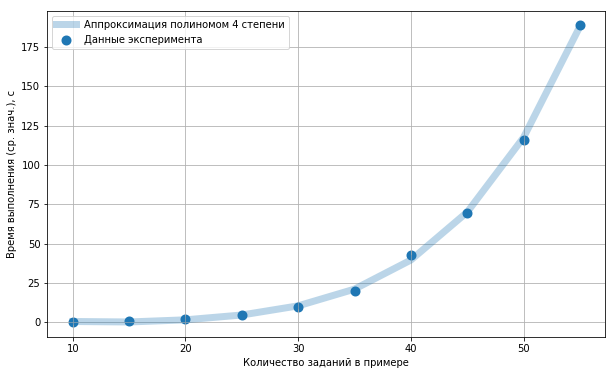

In [11]:
i = 4
x = list(map(int, list(results.keys())[:-1]))
y = list(map(lambda x: x[0], list(results.values())[:-1]))
z = approx(x, y, i)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Время выполнения (ср. знач.), с")
ax.plot(x, z(x), label='Аппроксимация полиномом %s степени' % (i),
        linewidth=7,
        alpha=0.3)
ax.legend()

## Функция аппроксимации

In [6]:
def approx(x, y, i):
    """
    Parameters:
     - x - x values list
     - y - y values list
     - i - polynome power
    Returns:
     numpy poly1d function
    """
    return np.poly1d(np.polyfit(list(map(float, x)),
                                list(map(float, y)),
                                i))

In [80]:
#results = {}
for i in range(300000):
    s = Schedule(4)
    bp, counter = main(s)
    if counter not in results.keys():
        results[counter] = 1
    else:
        results[counter] += 1
    if i % 100 == 0: print('\r', i, end='')

 700

KeyboardInterrupt: 

In [81]:
results

{16: 669, 10: 21, 14: 33}